# Compare swr detection with mua detection

The idea is that units should increase their firing during HPC ripples. Being so, ripples without increased unit firing might be false positives. 

In [1]:
import glob
import pandas as pd
import os
import pickle 
import numpy as np
import math 
from matplotlib import pyplot as plt

import sys
sys.path.append("/Users/ryanharvey/github/tg_ripples/tg_ripples")
from functions import *
import itertools
from ripple_detection.core import get_multiunit_population_firing_rate

from scipy import stats
from ripple_detection.core import gaussian_smooth, get_envelope

from neurodsp.filt import filter_signal


## Import mua data

In [2]:
df_mua = pd.read_csv('/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/multiunit_data/post_processed/mua_df.csv')
df_mua

,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group,rat
0,0,5.4355,5.4875,5.4625,0.052,ATN07_S20180918160054,ep_1,tg,ATN07
1,1,8.1655,8.2825,8.2005,0.117,ATN07_S20180918160054,ep_1,tg,ATN07
2,2,23.2005,23.2645,23.2325,0.064,ATN07_S20180918160054,ep_1,tg,ATN07
3,3,23.4695,23.5565,23.5025,0.087,ATN07_S20180918160054,ep_1,tg,ATN07
4,4,24.9545,25.0805,24.9845,0.126,ATN07_S20180918160054,ep_1,tg,ATN07
...,...,...,...,...,...,...,...,...,...
64279,64279,3165.4925,3165.6025,3165.5705,0.110,ATN15_S20190425170132,1,tg,ATN15
64280,64280,3166.6725,3166.8185,3166.7465,0.146,ATN15_S20190425170132,1,tg,ATN15
64281,64281,3170.8245,3170.9305,3170.8995,0.106,ATN15_S20190425170132,1,tg,ATN15
64282,64282,3186.5725,3186.6945,3186.6195,0.122,ATN15_S20190425170132,1,tg,ATN15


## load raw swr

In [3]:
save_path = "/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/swr_data/"
sessions = glob.glob(save_path + '*.pkl')
ripple_map = []
filtered_map = []
phase_map = []
amp_map = []

freq_map = []

df_swr=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        ripple_times = pickle.load(f)
        ripple_maps = pickle.load(f)
    ripple_map.append(ripple_maps["ripple_map"])
    filtered_map.append(ripple_maps['filtered_map'])
    phase_map.append(ripple_maps['phase_map'])
    amp_map.append(ripple_maps['amp_map'])
    freq_map.append(ripple_maps['freq_map'])

    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    ripple_times['session'] = os.path.splitext(base)[0]
    df_swr = df_swr.append(ripple_times,ignore_index=True)

ripple_map = np.vstack(ripple_map)     
filtered_map = np.vstack(filtered_map)     
phase_map = np.vstack(phase_map)     
amp_map = np.vstack(amp_map)     
freq_map = np.vstack(freq_map) 

# make maps dict 
ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}
df_swr

,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,0,5.187984,5.296984,0.109000,5.213984,2,14.856512,114.658358,0.000000,ATN07_S20180918160054
1,1,12.953961,13.048961,0.095000,13.006961,1,7.100278,106.166185,0.013333,ATN07_S20180918160054
2,2,18.848943,18.891943,0.043000,18.872943,4,5.459351,124.329890,0.000000,ATN07_S20180918160054
3,3,122.934630,123.013630,0.079000,122.992630,1,3.561854,101.900971,0.013333,ATN07_S20180918160054
4,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054
...,...,...,...,...,...,...,...,...,...,...
42926,25,2240.272126,2245.408106,5.135980,2242.697117,2,27.580630,144.055828,0.000000,ATN15_S20190416124013
42927,26,2249.643089,2249.741089,0.098000,2249.667089,4,7.044463,114.875884,0.000000,ATN15_S20190416124013
42928,27,2255.678065,2258.508054,2.829989,2257.196059,4,9.991996,120.272978,0.000000,ATN15_S20190416124013
42929,28,2303.530876,2303.612875,0.082000,2303.571876,7,5.325660,98.091713,0.000000,ATN15_S20190416124013


### Add area to ripple df

In [4]:
# channel_list = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\channel_list.csv')
# # channel_list

# area = []
# for ripple in df_swr.itertuples():
#     idx = (ripple.session == channel_list.session) & (ripple.peak_channel+1 == channel_list.channel)
#     area.append(channel_list[idx].area.iloc[0])
    
# df_swr['area'] = area
# df_swr

### do some slight processing to remove some obvious false positives

Below, I keep ripple that are less than 1 second

In [5]:
# remove less than a second from swr
idx = df_swr.ripple_duration < 1
for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
df_swr = df_swr[idx]

# remove less than a second from mua
df_mua = df_mua[df_mua.ripple_duration < 1]


display(df_swr)
display(df_mua)

,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,0,5.187984,5.296984,0.109000,5.213984,2,14.856512,114.658358,0.000000,ATN07_S20180918160054
1,1,12.953961,13.048961,0.095000,13.006961,1,7.100278,106.166185,0.013333,ATN07_S20180918160054
2,2,18.848943,18.891943,0.043000,18.872943,4,5.459351,124.329890,0.000000,ATN07_S20180918160054
3,3,122.934630,123.013630,0.079000,122.992630,1,3.561854,101.900971,0.013333,ATN07_S20180918160054
4,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054
...,...,...,...,...,...,...,...,...,...,...
42923,22,2221.201202,2221.461201,0.259999,2221.226202,4,9.570275,92.933327,0.006667,ATN15_S20190416124013
42925,24,2236.841140,2236.963139,0.122000,2236.941140,2,5.627344,131.654757,0.000000,ATN15_S20190416124013
42927,26,2249.643089,2249.741089,0.098000,2249.667089,4,7.044463,114.875884,0.000000,ATN15_S20190416124013
42929,28,2303.530876,2303.612875,0.082000,2303.571876,7,5.325660,98.091713,0.000000,ATN15_S20190416124013


,Unnamed: 0,start_time,end_time,peak_time,ripple_duration,session,ep_type,group,rat
0,0,5.4355,5.4875,5.4625,0.052,ATN07_S20180918160054,ep_1,tg,ATN07
1,1,8.1655,8.2825,8.2005,0.117,ATN07_S20180918160054,ep_1,tg,ATN07
2,2,23.2005,23.2645,23.2325,0.064,ATN07_S20180918160054,ep_1,tg,ATN07
3,3,23.4695,23.5565,23.5025,0.087,ATN07_S20180918160054,ep_1,tg,ATN07
4,4,24.9545,25.0805,24.9845,0.126,ATN07_S20180918160054,ep_1,tg,ATN07
...,...,...,...,...,...,...,...,...,...
64279,64279,3165.4925,3165.6025,3165.5705,0.110,ATN15_S20190425170132,1,tg,ATN15
64280,64280,3166.6725,3166.8185,3166.7465,0.146,ATN15_S20190425170132,1,tg,ATN15
64281,64281,3170.8245,3170.9305,3170.8995,0.106,ATN15_S20190425170132,1,tg,ATN15
64282,64282,3186.5725,3186.6945,3186.6195,0.122,ATN15_S20190425170132,1,tg,ATN15


In [6]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def get_lfp(df,i):
    data_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/ProcessedData/'

    # get data session path from mat file
    path = get_session_path(data_path+df_swr.session.iloc[i])
    file_sep=os.path.sep

    path = glob.glob((data_path.split('ClarkP30_Recordings')[0]+
              path.split('\\')[-4]+
              file_sep+
              '**'+
              file_sep+path.split('\\')[-1]+file_sep),
              recursive=True)
    path=path[0]
    
    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +file_sep+'*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

#### Pull in lfp and mua to plot example

In [8]:
def plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,session,lims=20,rip_n=0):
    # look at current session only
    df = df[(df.session == session)]
    
    # find time window around ripple
    lower_lim = df.peak_time.iloc[rip_n] - lims
    upper_lim = df.peak_time.iloc[rip_n] + lims
    
    # locate channel that maximized ripple power
    peak_ch = df.peak_channel.iloc[rip_n]
    
    # restrict to just that time window
    temp_df = df[(df.start_time >= lower_lim) & (df.end_time <= upper_lim)]
    
    # find index for time window for lfp
    lfp_idx = (ts_lfp >= lower_lim) & (ts_lfp <= upper_lim)
    
    # zscore lfp for plotting
    zscore_lfp = stats.zscore(lfp[lfp_idx,peak_ch],axis=0)
    
    # plot lfp trace
    ax.plot(ts_lfp[lfp_idx],zscore_lfp + 5,color='#0b032a',label='raw lfp')  
    
    # bandpass filter lfp trace to ripple range and zscore for plotting
    signal = stats.zscore(filter_signal(lfp[lfp_idx,peak_ch],1250,'bandpass',(80,250),remove_edges=False),axis=0)    
    
    # plot filtered signal
    ax.plot(ts_lfp[lfp_idx],signal,color='#621940',alpha=.5,label='filtered lfp') 
    
    # get envelope
    smooth_envelope = gaussian_smooth(get_envelope(signal),0.004,1250)
    ax.plot(ts_lfp[lfp_idx],smooth_envelope,color='#843b62',label='envelope') 
    
    # find index for time window for mua
    mua_idx = (ts_mua >= lower_lim) & (ts_mua <= upper_lim)
    
    # plot zscored mua
    ax.plot(ts_mua[mua_idx],stats.zscore(firing_rate[mua_idx],axis=0)-10,color='#ED553B',label='mua')

    # plot spike raster within window
    for i,s in enumerate(spike_times):
        s = s[(s >= lower_lim) & (s <= upper_lim)]
        ax.plot(s,np.zeros(len(s))-15-i,'|',color='#0b032a')

    # plot swr times within window
    for ripple in temp_df.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#843b62', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#843b62', zorder=1000)

    # plot mua times within window
    temp_df_mua = df_mua[(df_mua.session == session) & (df_mua.start_time >= lower_lim) & (df_mua.end_time <= upper_lim)]
    for ripple in temp_df_mua.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#ED553B', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#ED553B', zorder=1000)
        
    ax.legend(loc='upper right')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('time (sec)')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

### load data to plot example

In [10]:
spike_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/analysis/spikes'

session = np.where(df_swr.session=='ATN10_S20180822115910')[0][0]
# session = np.where(df_swr.session=='LS19_S20170622141707')[0][0]

lfp,ts_lfp = get_lfp(df_swr,session)

# load spikes
data_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/ProcessedData/'
spike_times = np.load(os.path.join(spike_path,df_swr.session.iloc[session])+'.npy', allow_pickle=True)

# bin spikes into single vector
st = list(itertools.chain.from_iterable(spike_times))
dt = 0.001
multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
# timestamps for binned spikes
ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

### plot example

* Shaded purple are detected ripple events

* Shaded orange are detected mua events

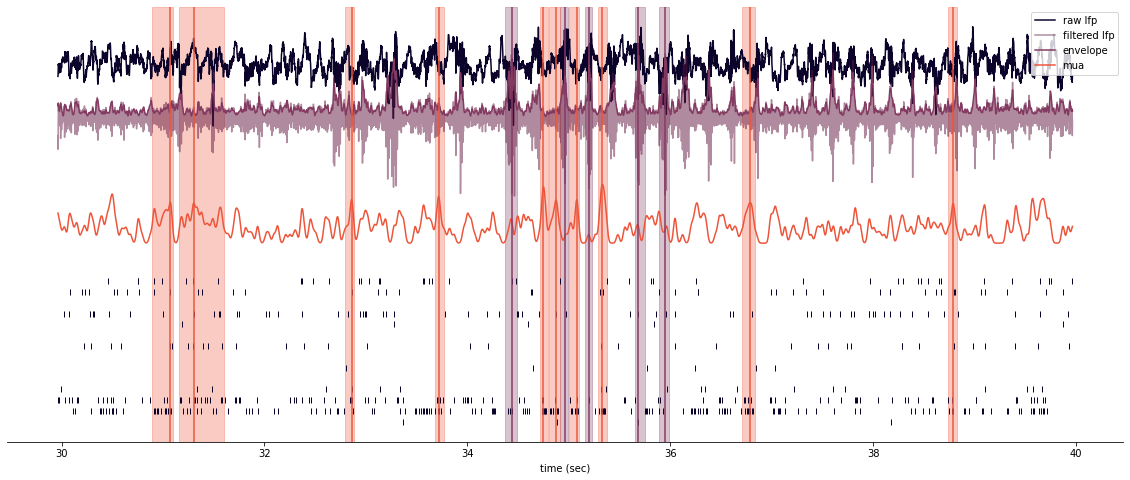

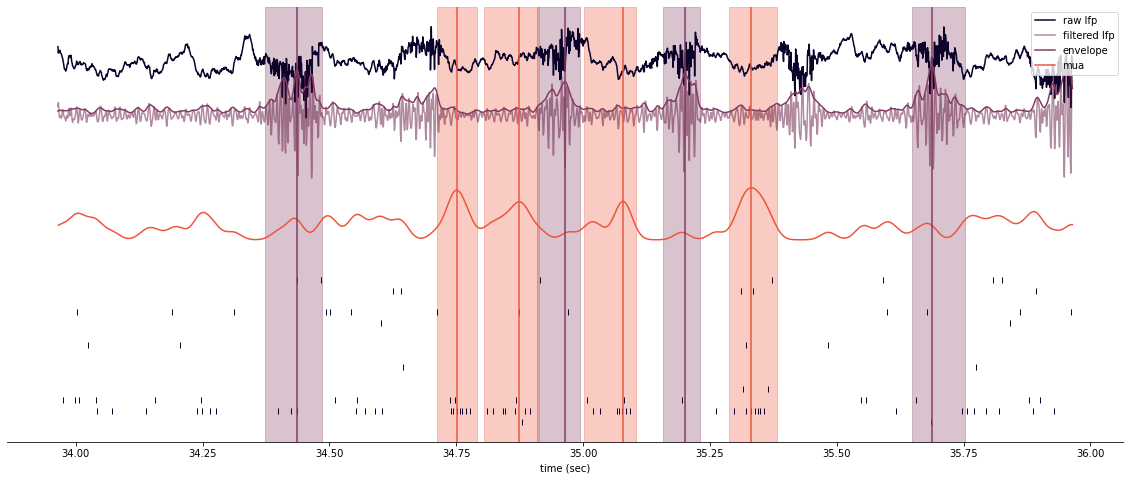

In [11]:
rip_n = 5
fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=1,rip_n=rip_n)

### check to find detected ripples overlap with of mua events

In [13]:
ripple_map_temp = []
filtered_map_temp = []
phase_map_temp = []
amp_map_temp = []
freq_map_temp = []

df=pd.DataFrame()

# from IPython.display import clear_output
# i=1

condition = []
for event in df_mua.itertuples():
    condition.append((df_swr.session == event.session) & (df_swr.peak_time >= event.start_time) & (df_swr.end_time <= event.end_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.start_time) & (df_swr.end_time >= event.start_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.end_time) & (df_swr.end_time >= event.end_time))
    idx = condition[0] | condition[1] | condition[2]
    condition = [] 
        
    ripple_map_temp.append(ripple_maps["ripple_map"][idx])
    filtered_map_temp.append(ripple_maps["filtered_map"][idx])
    phase_map_temp.append(ripple_maps["phase_map"][idx])
    amp_map_temp.append(ripple_maps["amp_map"][idx])
    freq_map_temp.append(ripple_maps["freq_map"][idx])

    event_times = df_swr[idx]
    df = df.append(event_times,ignore_index=True)
    
    # i+=1

ripple_map = np.vstack(ripple_map_temp)
filtered_map = np.vstack(filtered_map_temp)     
phase_map = np.vstack(phase_map_temp)     
amp_map = np.vstack(amp_map_temp)     
freq_map = np.vstack(freq_map_temp)  

ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}

df 

,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054
1,37,1249.616538,1249.689538,0.073000,1249.655538,4,4.094174,162.455893,0.000000,ATN07_S20180918160054
2,57,1528.019700,1528.132700,0.113000,1528.053700,5,3.569597,131.126268,0.000000,ATN07_S20180918160054
3,58,1581.596539,1581.788538,0.191999,1581.741538,4,9.663464,142.733218,0.006667,ATN07_S20180918160054
4,82,2764.205267,2764.258267,0.053000,2764.234267,3,10.114827,119.693525,0.006667,ATN07_S20180918160054
...,...,...,...,...,...,...,...,...,...,...
6042,15,1372.227543,1372.310542,0.083000,1372.287543,3,8.187005,108.978288,0.013333,ATN15_S20190425170132
6043,17,2159.908836,2160.734833,0.825996,2160.520834,7,13.361331,113.397813,0.020000,ATN15_S20190425170132
6044,18,2178.055751,2178.344750,0.288999,2178.217750,3,82.747517,103.436299,0.000000,ATN15_S20190425170132
6045,39,3137.493236,3138.105233,0.611997,3137.730235,7,6.972658,95.993009,0.000000,ATN15_S20190425170132


### remove duplicates

In [14]:
idx = (~df.start_time.duplicated(keep='first')) & (~df.peak_freq.duplicated(keep='first'))

df = df[idx]
for key in ripple_maps.keys():
    ripple_maps[key] = ripple_maps[key][idx]
df

,ripple_number,start_time,end_time,ripple_duration,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session
0,4,201.332394,201.366394,0.034000,201.351394,4,5.150545,122.931880,0.006667,ATN07_S20180918160054
1,37,1249.616538,1249.689538,0.073000,1249.655538,4,4.094174,162.455893,0.000000,ATN07_S20180918160054
2,57,1528.019700,1528.132700,0.113000,1528.053700,5,3.569597,131.126268,0.000000,ATN07_S20180918160054
3,58,1581.596539,1581.788538,0.191999,1581.741538,4,9.663464,142.733218,0.006667,ATN07_S20180918160054
4,82,2764.205267,2764.258267,0.053000,2764.234267,3,10.114827,119.693525,0.006667,ATN07_S20180918160054
...,...,...,...,...,...,...,...,...,...,...
6041,12,1275.821997,1275.857996,0.036000,1275.841996,2,6.866176,132.811124,0.006667,ATN15_S20190425170132
6042,15,1372.227543,1372.310542,0.083000,1372.287543,3,8.187005,108.978288,0.013333,ATN15_S20190425170132
6043,17,2159.908836,2160.734833,0.825996,2160.520834,7,13.361331,113.397813,0.020000,ATN15_S20190425170132
6044,18,2178.055751,2178.344750,0.288999,2178.217750,3,82.747517,103.436299,0.000000,ATN15_S20190425170132


### add epoch data to dataframe

In [15]:
def add_epoch_type(df,data_path):
    dicts = {}
    for session in df.session:
        f = h5py.File(data_path+session+'.mat','r')
        ex_ep = []
        for i in range(f['events'].shape[0]):
            ex_ep.append(f['events'][i])
        dicts[session] = ex_ep

    ep_type = ['ep_1','ep_2','ep_3','ep_4','ep_5']
    df['ep_type'] = np.ones_like(df.session)
    # session_df=pd.DataFrame()
    for session in np.unique(df.session):
        # stack epoch times
        b = np.hstack(dicts[session])

        # add 0 to start to indicate the start of the recording session
#         b = np.insert(b,0,0)

        # add the ts of the last ripple of the session to indicate end of session
        b = list(b)
        last_rip = max(df.end_time[df.session == session])
        if b[-1] < last_rip:
            b.append(last_rip)

        # loop through each epoch and label each ripple
        for ep in range(len(dicts[session])):
            idx = (df.session == session) & (df.peak_time >= b[ep]) & (df.peak_time <= b[ep+1])
            df.loc[idx,'ep_type'] = ep_type[ep]

    return df

data_path = '/Volumes/Seagate Backup Plus Drive/Projects/ClarkP30_Recordings/ProcessedData/'
df = add_epoch_type(df,data_path)


<ipython-input-15-480da9169425>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ep_type'] = np.ones_like(df.session)
/opt/anaconda3/envs/tg_ripples/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/envs/tg_ripples/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### add group affiliation to dataframe

In [16]:
def add_group_affiliation(df):
    tg = ('ATN07','ATN15')
    wt = ('ATN08','ATN10','ATN17')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(wt)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'wt'

    regstr = '|'.join(tg)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'tg'
    return df
    
df = add_group_affiliation(df)    

rat = [s.split('_')[0] for s in df.session]
df['rat']=rat

<ipython-input-16-156db7cc2a87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = np.ones_like(df.session)
<ipython-input-16-156db7cc2a87>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rat']=rat


### get ripple rate

Here, I am looking at how many ripples occured per second out of the valid time epochs where running speed was less than 4cm/sec

In [ ]:
# def get_ripple_rate(df,session,data_path):
#     # get_ripple_rate: returns ripple rate in hz

#     # load position data to get valid session duration
#     pos_df = load_position(data_path + df.session[df.session==session].iloc[0] + '.mat') 
#     # find time that ripples can occur (speeds < 4cm/sec)
#     valid_time = sum(pos_df.speed < 4) * (pos_df.ts.iloc[1] - pos_df.ts.iloc[0]) 
#     # divide the number of ripples by the amount of valid time in seconds to get ripples/sec
#     return sum(df.session == session) / valid_time

# # loop though each session to get ripples/sec
# ripple_rate = [get_ripple_rate(df,session,data_path) for session in pd.unique(df.session)]

# # make new dataframe where each row is a session
# df_ripple_rate = pd.DataFrame()
# df_ripple_rate["ripple_rate"] = ripple_rate

# df_ripple_rate["session"] = pd.unique(df.session)

# df_ripple_rate = add_group_affiliation(df_ripple_rate)

# display(df_ripple_rate)

In [17]:

def get_ripple_rate(df,event,data_path):
    # load position data to get valid session duration
    pos_df = load_position(data_path+event.session) 
    # find time that ripples can occur (speeds < 4cm/sec)
    valid_time = sum(pos_df.speed < 4) * (pos_df.ts.iloc[1] - pos_df.ts.iloc[0]) 
    # divide the number of ripples by the amount of valid time in seconds to get ripples/sec
    return event.counts / valid_time

df_ripple_rate = df.groupby(['session']).size().reset_index().rename(columns={0:'counts'})
# loop though each session to get ripples/sec
ripple_rate = [get_ripple_rate(df,event,data_path) for event in df_ripple_rate.itertuples()]
df_ripple_rate["ripple_rate"] = ripple_rate
df_ripple_rate = add_group_affiliation(df_ripple_rate)

rat = [s.split('_')[0] for s in df_ripple_rate.session]
df_ripple_rate['rat']=rat

display(df_ripple_rate)


,session,counts,ripple_rate,group,rat
0,ATN07_S20180712182441,24,0.027726,tg,ATN07
1,ATN07_S20180713161814,8,0.005633,tg,ATN07
2,ATN07_S20180717141215,75,0.020775,tg,ATN07
3,ATN07_S20180723173344,69,0.024225,tg,ATN07
4,ATN07_S20180724171203,61,0.029175,tg,ATN07
...,...,...,...,...,...
74,ATN17_S20190820130416,218,0.202943,wt,ATN17
75,ATN17_S20190826120645,96,0.094149,wt,ATN17
76,ATN17_S20190906163739,77,0.059032,wt,ATN17
77,ATN17_S20190916163012,34,0.062978,wt,ATN17


### save new df and maps

In [18]:
if not os.path.exists(save_path+'post_processed'):
    os.mkdir(save_path+'post_processed')

df.to_csv(save_path+'post_processed/swr_df.csv')
df_ripple_rate.to_csv(save_path+'post_processed/df_ripple_rate.csv')

# save file
with open(save_path+'post_processed/swr_df_maps.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(ripple_maps, f)

### plot example with new df where ripples must overlap mua

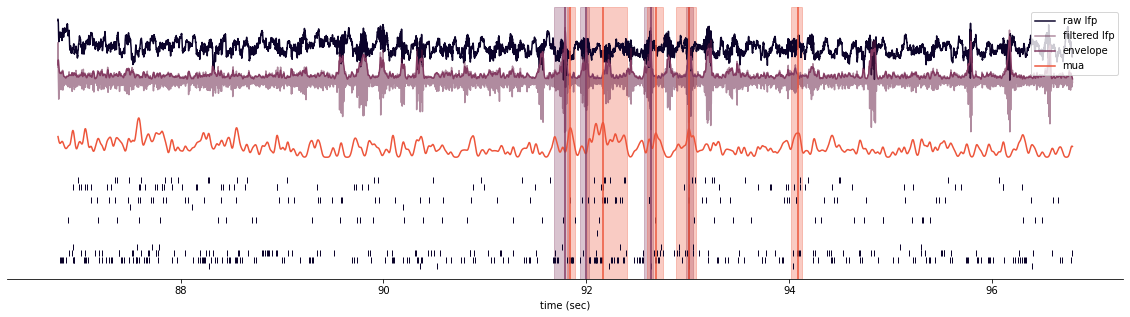

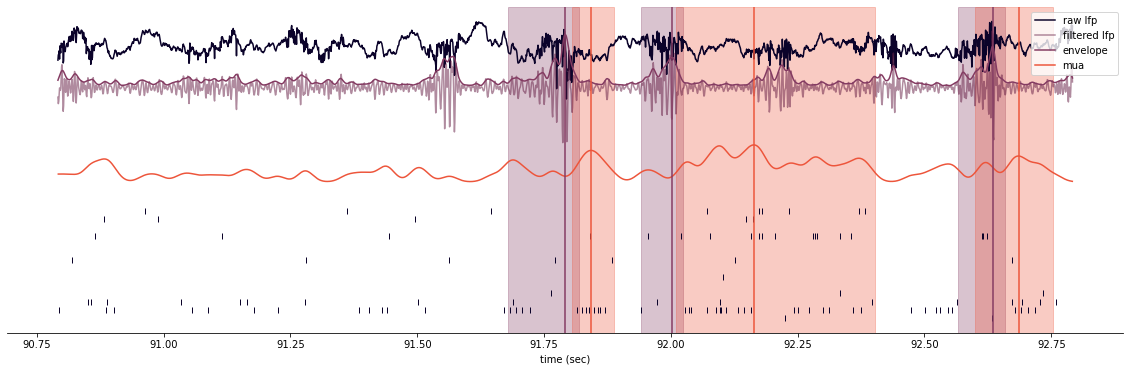

In [19]:
rip_n = 6
fig, ax = plt.subplots(1,1,figsize=(20, 5))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=1,rip_n=rip_n)

### make sure the overlap between ripple and mua is substantial

In [ ]:
# def get_mua_fr(session,dt = 0.001):
#     # load spikes
#     data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
#     spike_times = get_spikes(data_path+session+'.mat')
#     # bin spikes into single vector
#     st = list(itertools.chain.from_iterable(spike_times))
#     multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
#     # timestamps for binned spikes
#     ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
#     return ts_mua,get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

# def get_percent_overlap(df):
#     above_mean = []
#     # loop through each session
#     for session in pd.unique(df.session):
#         # pull out individual session
#         temp_df = df[df.session == session]
#         # get z scored mua firing rate
#         ts_mua, fr = get_mua_fr(session)
#         zscored_fr = stats.zscore(fr,axis=0)
#         # loop through each ripple event
#         for event in temp_df.itertuples():
#             # pull out mua firing rate during ripple
#             mua_values = zscored_fr[(ts_mua >= event.start_time) & (ts_mua <= event.end_time)]
#             # calculate the proportion where mua values are above the mean and save
#             above_mean.append(sum(mua_values > 0) / len(mua_values))
#     return above_mean

# above_mean = get_percent_overlap(df)
# df['ripple_mua_overlap'] = above_mean

# plt.figure(figsize=(20,4))
# plt.plot(above_mean)

# plt.figure(figsize=(4,4))
# plt.hist(above_mean,100)
# plt.show()


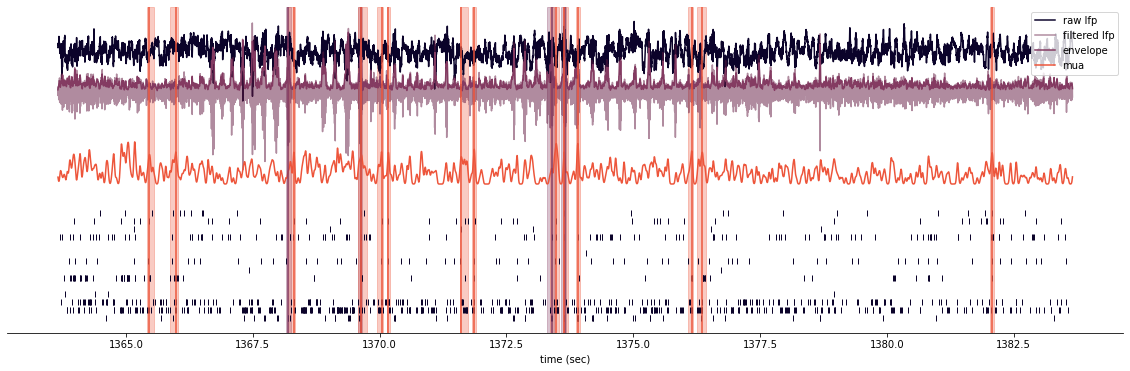

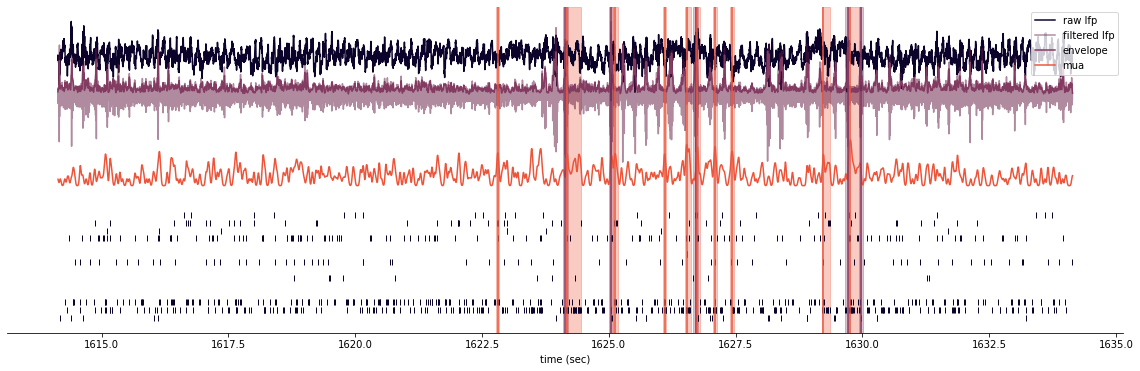

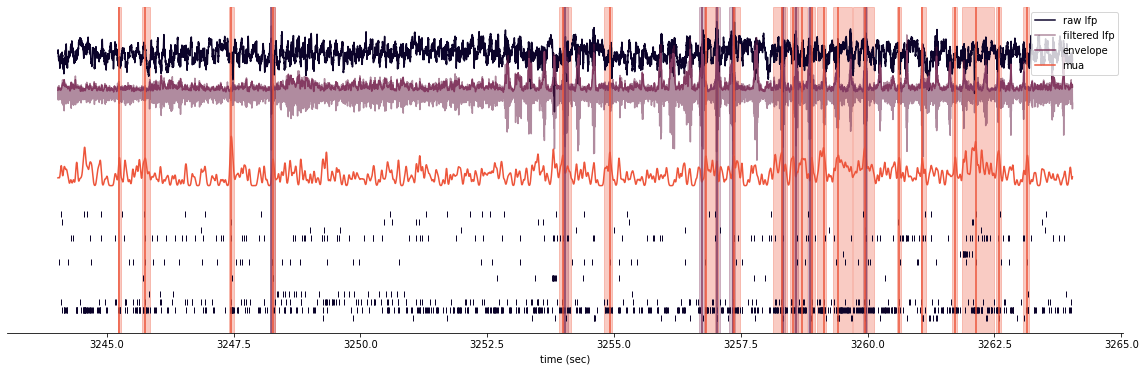

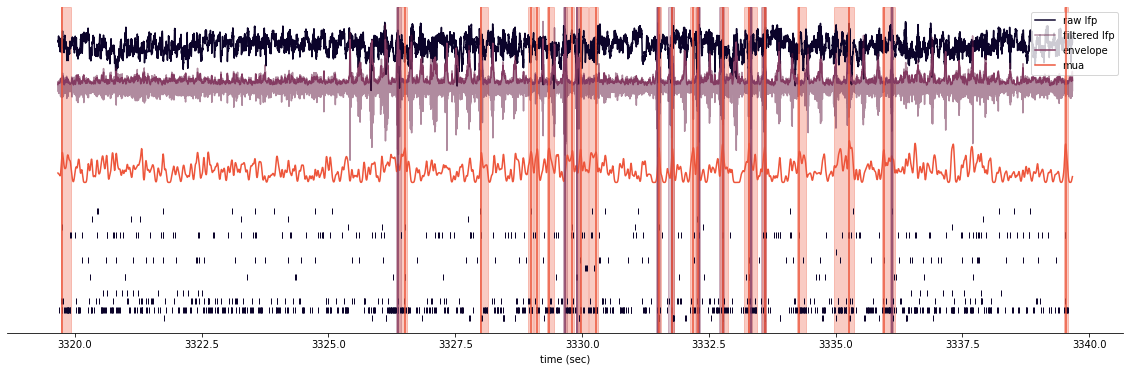

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=10,rip_n=92)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=10,rip_n=107)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=10,rip_n=294)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'ATN10_S20180822115910',lims=10,rip_n=307)

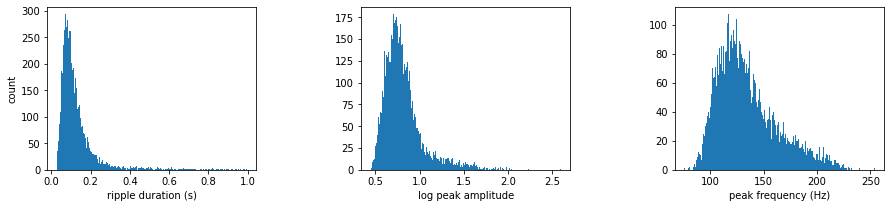

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

axs[0].hist(df.ripple_duration,200)
axs[0].set_ylabel('count')
axs[0].set_xlabel('ripple duration (s)')

axs[1].hist(np.log10(df.peak_amplitude),200)
axs[1].set_xlabel('log peak amplitude')

axs[2].hist(df.peak_freq,200)
axs[2].set_xlabel('peak frequency (Hz)')

plt.show()

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['ripple_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['freq_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['filtered_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['amp_map'][idx].T)
    axs[i].set_title(s)